In [1]:
%matplotlib notebook

import random
import numpy as np

np.random.seed(1000)
random.seed(1000)

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import math
import datetime

from mpl_toolkits.mplot3d import Axes3D


In [2]:
excel_file_name = "rc.xlsx"
neighbours_id_column_name = "nids"
uses_column_name = "uses"
coordinates_column_name = "coordinates"
population_density_column_name = "pop_density"
result_output_file_name = "new-rc.csv" # it should be csv format. excel will read the file
obj_function_result_file_name = "obj_fun.csv"

In [3]:
population_size = 40
max_training_iterations = 1000
tournament_selection_size = 10 # tournament size to select parents for crossover
parents_to_keep = -1 # if -1, keep half of the original population to the next generaiton
mutation_rate = 1.0 # if 1, 100% of the genes will have the chance to mutate. 
mutation_type = "single" # can be 'all' . If set to all, all values in an individial are subject to mutate.
    # in single case, it only swaps one elemnt with an other. 
crossover_type = "single_point" # can be 'uniform'
crossover_rate = 0.5
training_print_interval =  (max_training_iterations // 10) # prints by this value interval. 
                                                    # can be changed to 1 to max_training_iterations
                                                    # by defualt it prints 10 times only 

In [4]:
xls = pd.ExcelFile(excel_file_name) 
nids = pd.read_excel(xls, neighbours_id_column_name)
uses = pd.read_excel(xls, uses_column_name)
coordinates = pd.read_excel(xls, coordinates_column_name)
pop_density = pd.read_excel(xls, population_density_column_name)

In [7]:
cell2name = {}
cell2coord = {}
cell2neighbours = {}
cellvalue = []
cell2p = {}
for i in range(len(uses['S_ID']) - 1):
    idx = uses['S_ID'][i]
    name = uses['S_U'][i]
    
    cellvalue.append(name)
    cell2name[idx] = name
    cell2coord[idx] = (coordinates['X_Coord'][i], coordinates['Y_Coord'][i])

nid_np = nids.to_numpy()
for i in range(len(cell2name)):
    idx, neighbours = int(nid_np[i][0]), nid_np[i][1:]
    
    neighbours = [int(x) for x in neighbours if  not np.isnan(x)]
    cell2neighbours[idx] = neighbours

for i in range(len(cell2name)):
    idx = int(pop_density['S_ID'][i])
    p = float(pop_density['P_D'][i])
    cell2p[idx] = p

In [8]:
names = list(set(cell2name.values()))
idx2name = {k : v for k, v in enumerate(names)}
name2idx = {v : k for k, v in enumerate(names)}
print(name2idx)
cellvalue = np.array([name2idx[c] for c in cellvalue])

{'G': 0, 'B': 1, 'I': 2, 'S': 3, 'A': 4, 'R': 5, 'U': 6}


In [9]:
# color generation for ploting. Has nothing to do with this optimization
# used for ploting only
phi = np.linspace(0, 2*np.pi, len(idx2name))
x = np.sin(phi)
y = np.cos(phi)
rgb_cycle = np.vstack((            # Three sinusoids
    .5*(1.+np.cos(phi          )), # scaled to [0,1]
    .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
    .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

<IPython.core.display.Javascript object>


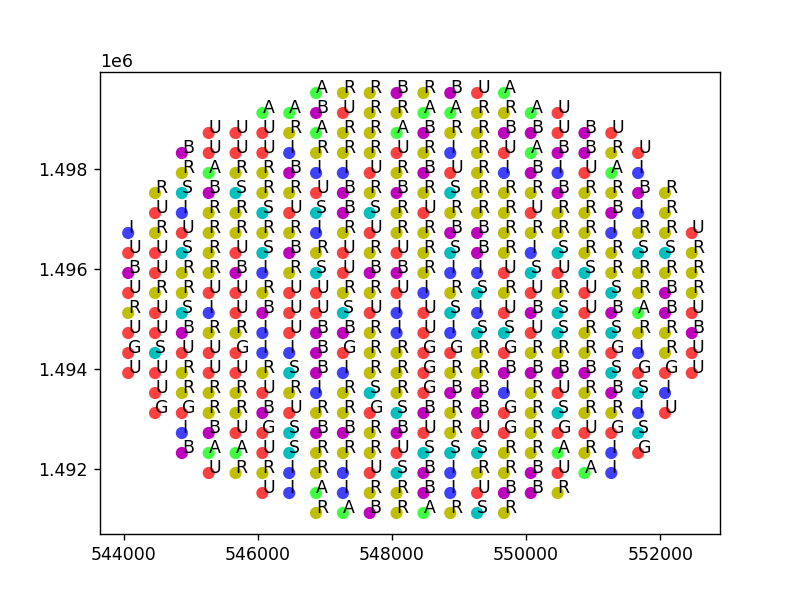

In [10]:
xs = []
ys = []
cs = []

fig, ax1 = plt.subplots(1, 1)
for key in cell2name.keys():
    x, y = cell2coord[key]
    name = cell2name[key]
    xs.append(x)
    ys.append(y)
    cs.append(rgb_cycle[names.index(name)])
    ax1.annotate(name, (x, y))

ax1.scatter(xs, ys,c=cs)
plt.show()

In [11]:
compat_index = ['A', 'B', 'G', 'I', 'R', 'S', 'U']
compat_index = [name2idx[x] for x in compat_index]
compat_index = {v : k for k, v in enumerate(compat_index)}

compat = np.array([
    [1,0.595, 0.667, 0.524, 0.548, 0.524,  0.31],
    [0.595, 1, 0.524, 0.571,0.714, 0.452, 0.143],
    [0.667, 0.524, 1, 0.667, 0.596, 0.691, 0.595],
    [0.524, 0.571, 0.667, 1, 0.214, 0.357,  0.619],
    [0.458, 0.714, 0.596, 0.214, 1, 0.691,  0.283],
    [0.524, 0.452, 0.691, 0.357, 0.691, 1, 0.452],
    [0.31, 0.143, 0.595, 0.619, 0.283, 0.452, 1]
])

access_index = ['A', 'B', 'G', 'I', 'R', 'S', 'U']
access_index = [name2idx[x] for x in access_index]
access_index = {v : k for k, v in enumerate(access_index)}

access = np.array([
    [0.00, 0.10, 0.03, 0.07, 0.20, 0.05, 0.00],
    [0.10, 0.00, 0.09, 0.17, 0.50, 0.13, 0.00],
    [0.03, 0.09, 0.00, 0.06, 0.17, 0.04, 0.00],
    [0.07, 0.17, 0.06, 0.00, 0.33, 0.08, 0.00],
    [0.20, 0.50, 0.17, 0.33, 0.00, 0.25 , 0.00],
    [0.05, 0.13, 0.04, 0.08, 0.25, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
])

conv_index = ['B', 'R', 'I', 'A', 'S', 'G', 'U']
conv_index = [name2idx[x] for x in conv_index]
conv_index = {v : k for k, v in enumerate(conv_index)}

total_conv_index = {'B':2.24, 'R':0.8, 'G':0.8, 'U':0.8, 'I':0.0, 'A':0.0, 'S':0.0}
total_conv = {idx: total_conv_index[name] for name, idx in name2idx.items()}

conversion = np.array([
    [0.0, -1.44, -2.44, -2.44, -2.44, -1.44, -1.44],
    [1.44 ,0.0, -0.8, -0.8, -0.8, 0.0, 0.0],
    [2.24 ,0.8, 0.0, 0.0, 0.0, 0.8, 0.8],
    [2.24, 0.8, 0.0, 0.0, 0.0, 0.8,  0.8],
    [2.24, 0.8, 0.0, 0.0 ,0.0, 0.8, 0.8],
    [1.44, 0.0, -0.8, -0.8, -0.8,0.0, 0.0],
    [1.44, 0.0, -0.8, -0.8, -0.8,  0.0, 0.0]
])

percent_index = ['B', 'R', 'I', 'S', 'A', 'G', 'U']
percent_index = [name2idx[x] for x in percent_index]
percent_index = {v : k for k, v in enumerate(percent_index)}
percent_bound = np.array([
    [15, 30], # B
    [45, 55], # R
    [5, 15], # I
    [10, 15], # S
    [3, 10],  # A
    [2, 5], # G
    [0, 5] # U
])
mid_percent = percent_bound.mean(axis=1)

In [12]:
def compat_obj_single(compat, cell2value, cell2neighbours, idx):
    """
    compute the compatability index of a cell with its neighbour
    """
    global compat_index
    c = 0
    for ids in cell2neighbours[idx]:
        c += compat[compat_index[cell2value[idx-1]], compat_index[cell2value[ids-1]]]
    return c 

def compat_obj_all(cell2value, cell2neighbours):
    """
    compute the compatability index of all cells with their neighbours
    """
    global compat
    c = 0
    for cell in cell2neighbours.keys():
        c += compat_obj_single(compat, cell2value, cell2neighbours, cell)
    return c

def access_obj_single(access, cell2value, cell2neighbours, idx, p):
    """
    computes the accessibility index of a cell with its neighbour
    """
    global access_index
    c = 0
    for ids in cell2neighbours[idx]:
        c += access[access_index[cell2value[idx-1]], access_index[cell2value[ids-1]]] * p
    return c 

def access_obj_all(cell2value, cell2neighbours):
    """
    computes the accessibility index of all cells with their neighbours
    """
    global access, cell2p
    c = 0
    for cell in cell2neighbours.keys():
        c += access_obj_single(access, cell2value, cell2neighbours, cell, cell2p[cell])
    return c

def conversion_obj_single(conversion, cell2value, cell2neighbours, idx):
    """
    compute the average conversion index of a cell with other use types
    """
    global conv_index
    c = 0
    for cell in range(len(conversion)):
        c += conversion[conv_index[cell2value[idx-1]], cell]
    return c / len(conversion)

def converion_obj_all(cell2value, cell2neighbours):
    """
    compute the average conversion index of all cells with other use types
    """
    global conversion
    c = 0
    for cell in cell2neighbours.keys():
        c += conversion_obj_single(conversion, cell2value, cell2neighbours, cell)
    return -c # to maximize, we add negative just like the word document shwos

def location_value_obj(cell2value, cell2neighbours):
    """
    computes the total land values
    """
    global conv_index, total_conv
    c = 0
    for k, v in enumerate(cell2value):
        c += total_conv[v]
    return c 

def percentage_obj(cell2value, cell2neighbours):
    """
    computes how each use type's percentage is correct with the specified percentage range.
    By setting the error to negatve value, we maximize it to make it zero
    """
    global percent_bound, idx2name
    per = {}
    for cv in cell2value:
        if cv not in per:
            per[cv] = 0
        per[cv] += 1
    s = 0
    for k in per.keys():
        val = per[k]*100/len(cell2value)
        low = percent_bound[percent_index[k]][0]
        high = percent_bound[percent_index[k]][1]
        if val <= low and val >= high:
            pass
        else:
            if val < low:
                s += (low - val)**2 # square the error
            elif val > high:
                s += (val - high)**2 # square the error
    return -np.sqrt(s) # make the error negative to maximize it. Take the square root so that it can be root mean square...
                    # root mean square is a better measurement than linearly adding


In [13]:
# list of objective functions
# comment a line if you want to disable it
# comment is done using # before the line

objective_functions = {
    "compatability_objective": compat_obj_all,    # maximizartion
    "accessibility_objective": access_obj_all,    # maximizartion
    "use_conversion_objective": converion_obj_all,    # maximizartion
    "location_value_objective": location_value_obj,    # maximizartion
    "percentage_objective": percentage_obj    # maximizartion
}


In [14]:
def calc_pop_objectives(pops, compat, access, conversion, total_conv, cell2neighbours):
    global objective_functions
    objective_scores = []
    for i in range(len(pops)):
        cell2value = pops[i]
        objs = []
        for key in objective_functions.keys():
            obj_fun = objective_functions[key]
            result = obj_fun(cell2value, cell2neighbours)
            objs.append(result)
        objective_scores.append(objs)
    return np.array(objective_scores)

def print_percentages(cellvalues):
    global percent_bound
    per = { }
    for i in cellvalues:
        if i not in per:
            per[i] = 0
        per[i] += 1

    for k in per:
        print(percent_bound[percent_index[k]], idx2name[k], per[k], per[k] * 100 / len(cellvalue), '%')


In [15]:
init_pop = np.zeros((population_size, len(cell2coord)))
strand = cellvalue[:]
others = np.where(strand != name2idx['B'])
others = strand[others]
Bs = np.where(strand == name2idx['B'], name2idx['B'], 0)
nonBIndex = np.where(strand != name2idx['B'])
loaded = 0
while True:
    s = Bs[:]
    
    temp = strand[nonBIndex].copy()
    np.random.shuffle(temp)
    s[nonBIndex] = temp
    
    if loaded == len(init_pop):
        break

    init_pop[loaded] = s
    
    loaded += 1

init_pop = init_pop.astype(np.int)


In [16]:
print_percentages(init_pop[0])

[ 5 15] I 40 10.0 %
[ 3 10] A 20 5.0 %
[15 30] B 60 15.0 %
[10 15] S 40 10.0 %
[0 5] U 80 20.0 %
[45 55] R 140 35.0 %
[2 5] G 20 5.0 %


In [17]:
def calculate_crowding(scores):
    """
    Crowding is based on a vector for each individual
    All scores are normalised between low and high. For any one score, all
    solutions are sorted in order low to high. Crowding for chromsome x
    for that score is the difference between the next highest and next
    lowest score. Total crowding value sums all crowding for all scores
    """
    
    population_size = len(scores[:, 0])
    number_of_scores = len(scores[0, :])

    # create crowding matrix of population (row) and score (column)
    crowding_matrix = np.zeros((population_size, number_of_scores))

    # normalise scores (ptp is max-min)
    normed_scores = (scores - scores.min(0)) / scores.ptp(0)

    # calculate crowding distance for each score in turn
    for col in range(number_of_scores):
        crowding = np.zeros(population_size)

        # end points have maximum crowding
        crowding[0] = 1
        crowding[population_size - 1] = 1

        # Sort each score (to calculate crowding between adjacent scores)
        sorted_scores = np.sort(normed_scores[:, col])

        sorted_scores_index = np.argsort(
            normed_scores[:, col])

        # Calculate crowding distance for each individual
        crowding[1:population_size - 1] = \
            (sorted_scores[2:population_size] -
             sorted_scores[0:population_size - 2])

        # resort to orginal order (two steps)
        re_sort_order = np.argsort(sorted_scores_index)
        sorted_crowding = crowding[re_sort_order]

        # Record crowding distances
        crowding_matrix[:, col] = sorted_crowding

    # Sum crowding distances of each score
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [18]:
def reduce_by_crowding(scores, number_to_select):
    """
    This function selects a number of solutions based on tournament of
    crowding distances. Two members of the population are picked at
    random. The one with the higher croding dostance is always picked
    """    
    population_ids = np.arange(scores.shape[0])

    crowding_distances = calculate_crowding(scores)

    picked_population_ids = np.zeros((number_to_select))

    picked_scores = np.zeros((number_to_select, len(scores[0, :])))

    for i in range(number_to_select):

        population_size = population_ids.shape[0]

        fighter1ID = rn.randint(0, population_size - 1)

        fighter2ID = rn.randint(0, population_size - 1)

        # If fighter # 1 is better
        if crowding_distances[fighter1ID] >= crowding_distances[fighter2ID]:

            fid = fighter1ID
            if crowding_distances[fighter1ID] == crowding_distances[fighter2ID]:
                fid = np.random.choice([fighter1ID, fighter2ID])
            # add solution to picked solutions array
            picked_population_ids[i] = population_ids[fid]

            # Add score to picked scores array
            picked_scores[i, :] = scores[fid, :]

            # remove selected solution from available solutions
            population_ids = np.delete(population_ids, (fid), axis=0)

            scores = np.delete(scores, (fid), axis=0)

            crowding_distances = np.delete(crowding_distances, (fid), axis=0)
        else:
            picked_population_ids[i] = population_ids[fighter2ID]

            picked_scores[i, :] = scores[fighter2ID, :]

            population_ids = np.delete(population_ids, (fighter2ID), axis=0)

            scores = np.delete(scores, (fighter2ID), axis=0)

            crowding_distances = np.delete(
                crowding_distances, (fighter2ID), axis=0)

    # Convert to integer 
    picked_population_ids = np.asarray(picked_population_ids, dtype=int)
    
    
    return (picked_population_ids)

In [19]:
def identify_pareto(scores, population_ids):
    """
    Identifies a single Pareto front, and returns the population IDs of
    the selected solutions.
    """
    population_size = scores.shape[0]
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]): # making it
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front], pareto_front

In [20]:
def build_pareto_population(population, scores, minimum_population_size, maximum_population_size):
    """
    As necessary repeats Pareto front selection to build a population within
    defined size limits. Will reduce a Pareto front by applying crowding 
    selection as necessary.    
    """
    unselected_population_ids = np.arange(population.shape[0], dtype=np.int)
    all_population_ids = np.arange(population.shape[0], dtype=np.int)
#     print(scores.shape)
    pareto_front = []
    pareto_front_labels = {}
    pareto_label_counter = 0
    while len(pareto_front) < minimum_population_size:
        temp_pareto_front, _pareto_front = identify_pareto(scores[unselected_population_ids, :], unselected_population_ids)
        pareto_front_labels[pareto_label_counter] = temp_pareto_front
        pareto_label_counter += 1
        # Check size of total parteo front. 
        # If larger than maximum size reduce new pareto front by crowding
        combined_pareto_size = len(pareto_front) + len(temp_pareto_front)
        if combined_pareto_size > maximum_population_size:
            number_to_select = combined_pareto_size - maximum_population_size
            selected_individuals = (reduce_by_crowding(
                    scores[temp_pareto_front], number_to_select))
            temp_pareto_front = temp_pareto_front[selected_individuals]
        
        # Add latest pareto front to full Pareto front
        pareto_front = np.hstack((pareto_front, temp_pareto_front))
        
        
        # Update unselected population ID by using sets to find IDs in all
        # ids that are not in the selected front
        unselected_set = set(all_population_ids) - set(pareto_front)
        unselected_population_ids = np.array(list(unselected_set))

    _population = population[pareto_front.astype(int)]
    return _population, population, pareto_front_labels

In [21]:
def uniform_crossover(parent1, parent2):
    child = parent1.copy() #start with oparent 1 gene, and updated it with parent 2 later
    
    rands = np.random.uniform(size=len(parent1))
    for i in range(len(parent1)):
        if rands[i] > .5 and parent1[i] != name2idx['B'] and parent2[i] != name2idx['B']:
            child[i] = parent2[i]
            
    return child

    
def single_point_crossover(parent1, parent2):
    child = parent1.copy() #start with oparent 1 gene, and updated it with parent 2 later
    
    strid1 = np.not_equal(parent1, name2idx['B']) # 1 for non-B values, 0 other wise
    strid2 = np.not_equal(parent2, name2idx['B'])  # 1 for non-B values, 0 other wise
    strid3 = strid1 * strid2  # 1 for non-B values, 0 other wise - applies on both parents
    
    n_gene = len(parent1) // 2 # chose half of crossable points
    allowed_indexes = np.where(strid3)[0] # get the allowed indexes to be crossed over.
    
    half = allowed_indexes[n_gene:] # take the half
    child[half] = parent2[half].copy() # copy from parent 2 to child
    
    return child

In [22]:
def breed(crossover_function, pop, to_size, k = 5, n_parent=-1):
    """
    Tournament selection followed by crossover. K is the tournament size to select a parent
    n_parent allows n parents from old generation to be in the new generation
    to_size specifies how many individuals the returned result holds. typically its the popultaiton size
    """
    childeren = []
    
    if n_parent  <= -1:
        n_parent = len(pop) // 2 # set how many of the old parents are needed to half of the pop_size
        
    for i in range(n_parent):
        childeren.append(pop[i]) #copy the top parents to the list
        
    while len(childeren) < to_size:
        k_selection1 = np.random.choice(len(pop), size=k, replace=True) # tournament 1 to select parent 1
        best1 = k_selection1.min()
        parent1 = pop[best1]

        k_selection2 = np.random.choice(len(pop), size=k, replace=True)  # tournament 2 to select parent 2
        best2 = k_selection2.min()
        parent2 = pop[best2]
        
        child  = crossover_function(parent1, parent2)
            
        childeren.append(child)
        
    return np.stack(childeren)
        

In [23]:
def single_mutuate(pop, mutuate_rate):
    for i in range(len(pop)):
        r = np.random.uniform()
        if r < mutuate_rate:
            r1, r2 = np.random.randint(low=0, high=len(pop[0]), size=2)
            # while we get good swapable r1 and r2, keep searching
            while r1 == r2 or pop[i][r1] == name2idx['B'] or pop[i][r2] == name2idx['B']: 
                r1, r2 = np.random.randint(low=0, high=len(pop[0]), size=2)
            
            # if there are good swapable cells, swap them
            pop[i][r1], pop[i][r2] = pop[i][r2], pop[i][r1]
            
    return pop


def all_mutuate(pop, mutuate_rate):
    for i in range(len(pop)):
        # for each value in the individual, go and mutate it if the probability allows it.
        for j in range(pop.shape[1] // 2):
            r = np.random.uniform()
            if r < mutuate_rate and pop[i][j] != name2idx['B'] and pop[i][pop.shape[1] - j - 1] != name2idx['B'] :
                pop[i][j], pop[i][pop.shape[1] - j - 1] = pop[i][pop.shape[1] - j - 1], pop[i][j]
    return pop


In [24]:
scores = calc_pop_objectives(init_pop, compat, access, conversion, total_conv, cell2neighbours)
print("Initial mean scores: ", [np.round(x, 2) for x in np.mean(scores, axis=0)])

if crossover_type == "uniform":
    crossover_function = uniform_crossover
else:
    crossover_function = single_point_crossover 

if mutation_type == "all":
    mutation_function = all_mutuate
else:
    mutation_function = single_mutuate
    
    
pop = init_pop.copy()
bests = []
means = []
epochs = max_training_iterations
time_taken = {"breed": [], "mutaiton": [], "objective": [], "pareto": []}

start_time = datetime.datetime.now() # training started time
total_epochs_taken = 0
for i in range(epochs):
    
    breed_start_time = datetime.datetime.now()
    pop = breed(crossover_function, pop, len(init_pop), k = tournament_selection_size, n_parent=parents_to_keep)
    time_taken["breed"].append((datetime.datetime.now() - breed_start_time).total_seconds())
    
    mutation_start_time = datetime.datetime.now()
    pop = mutation_function(pop, mutation_rate)
    time_taken["mutaiton"].append((datetime.datetime.now() - mutation_start_time).total_seconds())
    
    objective_start_time = datetime.datetime.now()
    scores = calc_pop_objectives(pop, compat, access, conversion, total_conv, cell2neighbours)
    time_taken["objective"].append((datetime.datetime.now() - objective_start_time).total_seconds())
    
    pareto_start_time = datetime.datetime.now()
    # pop = selected popuplation, prev_pop = unsorted population
    pop, prev_pop, pareto_front_labels = build_pareto_population(pop, scores, len(pop) // 2, len(pop))
    time_taken["pareto"].append((datetime.datetime.now() - pareto_start_time).total_seconds())

    mean = np.mean(scores, axis=0)
    means.append(mean)
    
    if i % training_print_interval == 0 and i > 0: 
        print([np.round(x, 3) for x in np.mean(scores, axis=0)])

        
    total_epochs_taken += 1

elapsed = (datetime.datetime.now() - start_time).total_seconds() # training ended time
means = np.stack(means)
print()
print("Total Time taken: {0:.4f} seconds".format(elapsed))
print("Time taken per episod: {0:.4f} seconds".format(elapsed / total_epochs_taken))
print("Breed Time taken per episod: {0:.4f} seconds".format(np.mean(time_taken["breed"])))
print("mutaiton Time taken per episod: {0:.4f} seconds".format(np.mean(time_taken["mutaiton"])))
print("objective calculation Time taken per episod: {0:.4f} seconds".format(np.mean(time_taken["objective"])))
print("pareto sorting Time taken per episod: {0:.4f} seconds".format(np.mean(time_taken["pareto"])))


Initial mean scores:  [1718.51, 362.27, 66.6, 326.4, -18.03]
[1793.758, 384.033, 81.003, 340.66, -14.781]
[1917.323, 421.971, 97.903, 357.76, -11.873]
[2055.865, 453.352, 108.723, 368.86, -8.511]
[2139.015, 472.166, 106.243, 366.38, -6.344]
[2158.605, 467.047, 101.103, 361.14, -4.542]
[2173.355, 464.705, 105.943, 365.82, -5.307]
[2202.28, 461.041, 106.523, 366.66, -5.93]
[2186.444, 455.876, 106.703, 366.8, -5.524]
[2219.109, 469.502, 102.223, 362.34, -5.385]

Total Time taken: 429.5637 seconds
Time taken per episod: 0.4296 seconds
Breed Time taken per episod: 0.0014 seconds
mutaiton Time taken per episod: 0.0009 seconds
objective calculation Time taken per episod: 0.4255 seconds
pareto sorting Time taken per episod: 0.0017 seconds


In [25]:

# save the function values
with open(obj_function_result_file_name, mode="w") as f:
    headline = ",".join([key for key in objective_functions.keys()])
    f.write(headline)
    f.write('\n')
    lines  = []
    for mean in means:
        line = ",".join([str(x) for x in mean])
        f.write(line)
        f.write('\n')

<IPython.core.display.Javascript object>


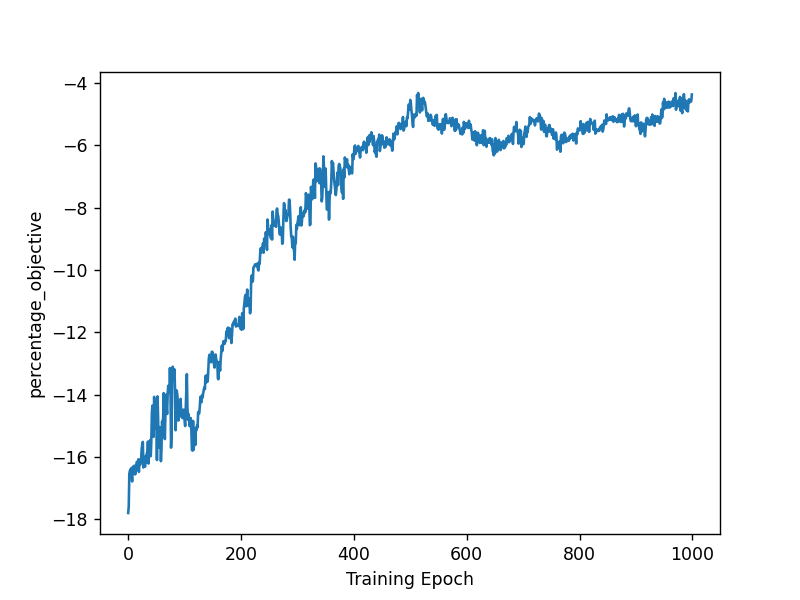

In [26]:
# "compatability_objective": compat_obj_all,    # maximizartion
# "accessibility_objective": access_obj_all,    # maximizartion
# "use_conversion_objective": converion_obj_all,    # maximizartion
# "location_value_objective": location_value_obj,    # maximizartion
# "percentage_objective": percentage_obj    # maximizartion

# plot objective functions over the training time
obj_labels = list(objective_functions.keys())
objective_name = "percentage_objective" # based on the list of the objective fuction, set this to get the graph, starting from 0
objective_index = obj_labels.index(objective_name)

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(means[:, objective_index])), means[:, objective_index])
ax.set_xlabel("Training Epoch")
ax.set_ylabel(obj_labels[objective_index])
plt.show()

# plot with range

<IPython.core.display.Javascript object>


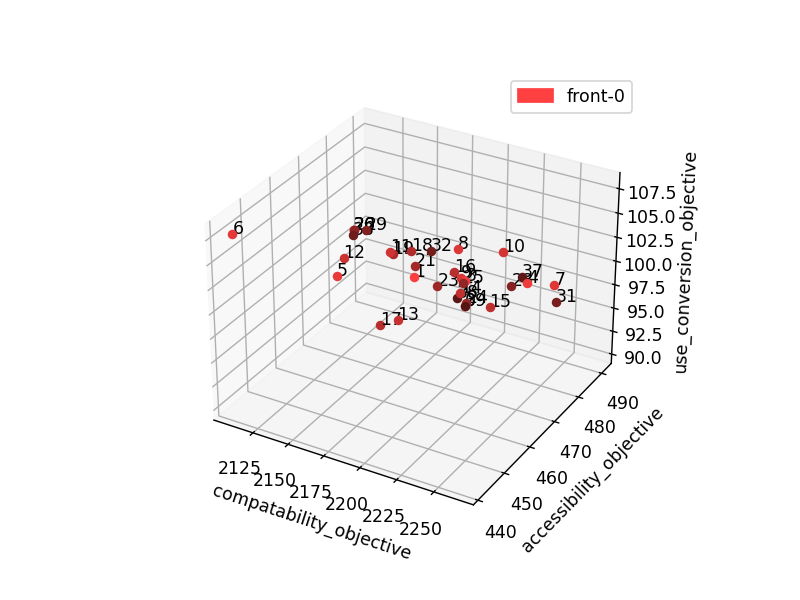

In [27]:
def plot_population(xdata, ydata, zdata, pareto_front_labels, xlabel, ylabel, zlabel):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    labels = {}
    for k, v in pareto_front_labels.items():
        for vv in v:
            labels[vv] = k
        
    unique_labels = list(set(pareto_front_labels.keys()))
    unique_labels = {v: k for k, v in enumerate(unique_labels)}
    # color generation for ploting. Has nothing to do with this optimization
    # used for ploting only
    phi = np.linspace(0, 20*np.pi, len(labels))
    x = np.sin(phi)
    y = np.cos(phi)
    
    rgb_cycle = np.vstack((            # Three sinusoids
        .5*(1.+np.cos(phi          )), # scaled to [0,1]
        .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
        .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)
    mx = max(labels.keys())
    for i in labels.keys():
        mu = (1 - i / mx) + .5
        mu =  mu / 1.5
        ax.scatter3D([xdata[i]], [ydata[i]], [zdata[i]], c=[mu*rgb_cycle[unique_labels[labels[i]]]], cmap='brg');
        label = "{0}".format(i)
#         label = "{0}-{1}".format(labels[i], i)
        ax.text(xdata[i], ydata[i], zdata[i], label)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    handles=[]
    for k, v in unique_labels.items():
        m = mpatches.Patch(color=rgb_cycle[k], label=("front-" + str(v)))
        handles.append(m)
        
    ax.legend(handles=handles)
    plt.show()

# "compatability_objective": compat_obj_all,    # maximizartion
# "accessibility_objective": access_obj_all,    # maximizartion
# "use_conversion_objective": converion_obj_all,    # maximizartion
# "location_value_objective": location_value_obj,    # maximizartion
# "percentage_objective": percentage_obj    # maximizartion


population_objectives = calc_pop_objectives(prev_pop, compat, access, conversion, total_conv, cell2neighbours)
obj_labels = list(objective_functions.keys())

x_index = obj_labels.index("compatability_objective")
y_index = obj_labels.index("accessibility_objective")
z_index = obj_labels.index("use_conversion_objective")

# the lighter, the better objective value
plot_population(population_objectives[:, x_index], 
                population_objectives[:, y_index], 
                population_objectives[:, z_index], 
                pareto_front_labels,
                obj_labels[x_index],
                obj_labels[y_index],
                obj_labels[z_index],
               )


<IPython.core.display.Javascript object>


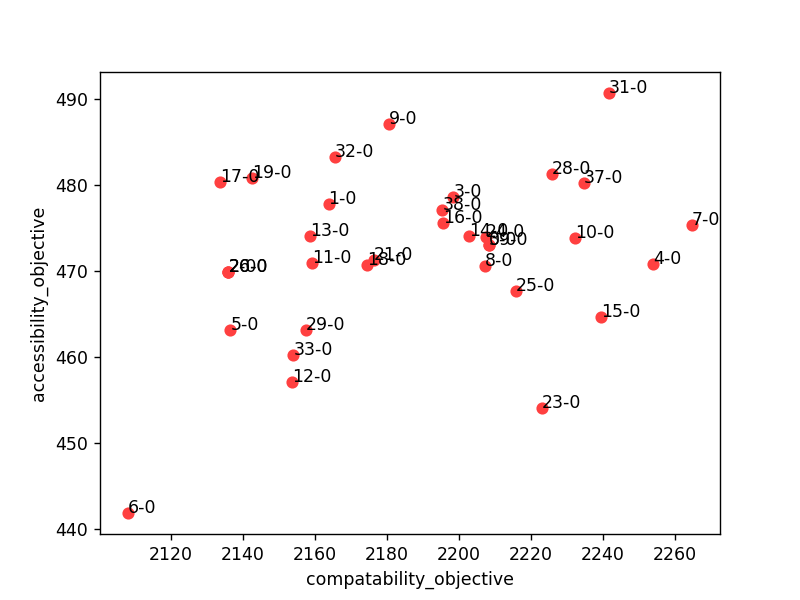

In [28]:
# 2d graph of the objective functions
fig, ax1 = plt.subplots(1, 1)
population_objectives = calc_pop_objectives(prev_pop, compat, access, conversion, total_conv, cell2neighbours)
labels = {}
for k, v in pareto_front_labels.items():
    for vv in v:
        labels[vv] = k
        
# "compatability_objective": compat_obj_all,    # maximizartion
# "accessibility_objective": access_obj_all,    # maximizartion
# "use_conversion_objective": converion_obj_all,    # maximizartion
# "location_value_objective": location_value_obj,    # maximizartion
# "percentage_objective": percentage_obj    # maximizartion

x_index = obj_labels.index("compatability_objective")
y_index = obj_labels.index("accessibility_objective")
xlabel = obj_labels[x_index]
ylabel = obj_labels[y_index]
for jj in labels.keys():
    ax1.scatter(population_objectives[:, x_index][jj], population_objectives[:,y_index][jj], c=[rgb_cycle[labels[jj]]])
    ax1.annotate(str(jj) + "-" + str(labels[jj]), (population_objectives[:, x_index][jj], population_objectives[:, y_index][jj]))

ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
plt.show()

<IPython.core.display.Javascript object>


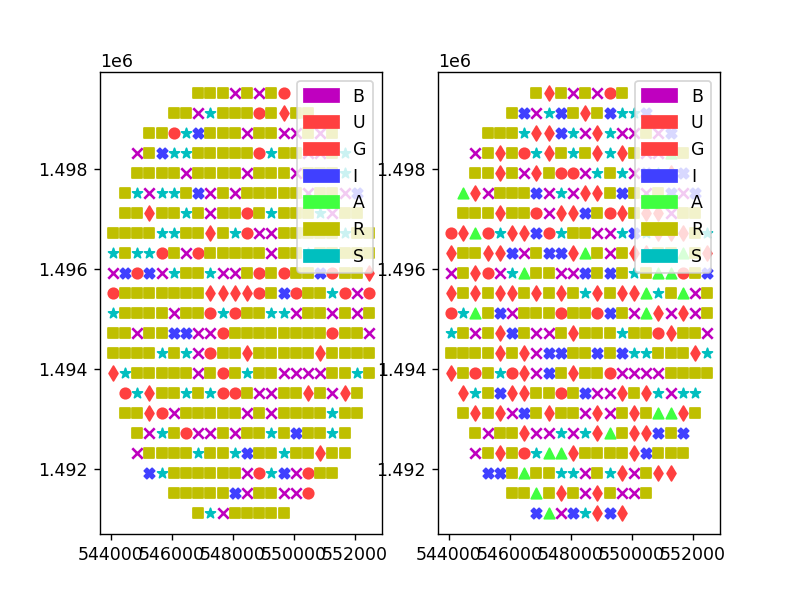

In [29]:
xs = []
ys = []
cs = []
markers = ['o', 'x', 'X', '*', '^', 's',  'd']
fig, (ax1, ax2) = plt.subplots(1, 2)
for i in range(len(pop[0])):
    key = pop[0][i]
    x, y = cell2coord[i+1]
    name = idx2name[key]
    ax1.scatter([x],[ y], c=[rgb_cycle[names.index(name)]], marker=markers[names.index(name)])

for i in range(len(init_pop[0])):
    key = init_pop[0][i]
    x, y = cell2coord[i+1]
    name = idx2name[key]
    ax2.scatter([x],[y], c=[rgb_cycle[names.index(name)]], marker=markers[names.index(name)])
    

handles=[
    mpatches.Patch(color=rgb_cycle[names.index('B')], label='B'),
    mpatches.Patch(color=rgb_cycle[names.index('U')], label='U'),
    mpatches.Patch(color=rgb_cycle[names.index('G')], label='G'),
    mpatches.Patch(color=rgb_cycle[names.index('I')], label='I'),
    mpatches.Patch(color=rgb_cycle[names.index('A')], label='A'),
    mpatches.Patch(color=rgb_cycle[names.index('R')], label='R'),
    mpatches.Patch(color=rgb_cycle[names.index('S')], label='S'),
]
ax1.legend(handles=handles)
ax2.legend(handles=handles)
plt.show()


In [30]:
print_percentages(pop[0])

[45 55] R 232 58.0 %
[10 15] S 46 11.5 %
[15 30] B 60 15.0 %
[ 5 15] I 15 3.75 %
[2 5] G 31 7.75 %
[0 5] U 16 4.0 %


In [31]:
# save the best from the population

best_individial = pop[0] # 0 can be changed to any number upto (pop_size - 1) . But the 0th places individual is the best
lines = ['S_ID, S_U, N1_ID, N2_ID, N3_ID, N4_ID, N5_ID, N6_ID, N7_ID, N8_ID']

for cell, neighbours in cell2neighbours.items():
    
    cell_use = best_individial[cell-1] # should be -1, so that the array starts from 0, not one
    cell_line = "{0}, {1}".format(cell, idx2name[cell_use])
    for neighbour in neighbours:
        cell_line += "," + str(idx2name[best_individial[neighbour-1]])
        
    lines.append(cell_line)
    
with open(result_output_file_name, mode='w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')
    